# Ocean interior carbon storage: Changes in preformed vs regenerated carbon

In [17]:
from dask.distributed import Client

client = Client("tcp://10.32.15.116:38649")
client

Client Scheduler: tcp://10.32.15.116:38649 Dashboard: /user/0000-0002-2993-7484/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 11.50 GB


In [18]:
%matplotlib inline

import xarray as xr
import intake
import numpy as np
from cmip6_preprocessing.preprocessing import read_data
import warnings

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [34]:
# Functions
def calc_o2sat_gsw(practical_salinity,potential_temperature,latitude,longitude,pressure):
    import gsw
    
    #Calculate Absolute Salinity
    gsw_as=xr.apply_ufunc(gsw.SA_from_SP,
                          practical_salinity,
                          pressure,
                          longitude,
                          latitude,
                          dask='parallelized',
                          output_dtypes=[practical_salinity.dtype])
    
    #Calculate Conservative Temperature
    gsw_ct=xr.apply_ufunc(gsw.CT_from_t,
                          gsw_as,
                          potential_temperature,
                          pressure,
                          dask='parallelized',
                          output_dtypes=[potential_temperature.dtype])

    #Calculate Oxygen Saturation
    gsw_o2sat=xr.apply_ufunc(gsw.O2sol,
                             gsw_as,
                             gsw_ct,
                             pressure,
                             longitude,
                             latitude,
                             dask='parallelized',
                             output_dtypes=[gsw_ct.dtype])*1.0245e-3 # Convert umol/kg to mol/m3

    return gsw_o2sat

def _compute_slope(y):
    """
    Private function to compute slopes at each grid cell using
    polyfit. 
    """
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] # return only the slope

def compute_slope(da):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
      da: xarray DataArray to compute slopes for
      
    Returns:
      xarray DataArray with slopes computed at each grid cell.
    """
    # apply_ufunc can apply a raw numpy function to a grid.
    # 
    # vectorize is only needed for functions that aren't already
    # vectorized. You don't need it for polyfit in theory, but it's
    # good to use when using things like np.cov.
    #
    # dask='parallelized' parallelizes this across dask chunks. It requires
    # an output_dtypes of the numpy array datatype coming out.
    #
    # input_core_dims should pass the dimension that is being *reduced* by this operation,
    # if one is being reduced.
    slopes = xr.apply_ufunc(_compute_slope,
                            da,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

In [20]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6_update_2019_10_18.json")

In [21]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [22]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical']:
    query = dict(experiment_id=experiment_id, 
                 grid_label='gn',
                 variable_id=['o2','thetao','so','dissic'])  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models=models-{'CanESM5','CESM2-WACCM','AWI-CM-1-1-MR'}
models = list(models)
models

['GFDL-CM4',
 'HadGEM3-GC31-LL',
 'CNRM-CM6-1',
 'SAM0-UNICON',
 'GISS-E2-1-G',
 'MCM-UA-1-0',
 'EC-Earth3-Veg',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'GFDL-ESM4',
 'MIROC6',
 'NESM3',
 'CNRM-ESM2-1',
 'GISS-E2-1-G-CC',
 'CESM2',
 'MIROC-ES2L',
 'FGOALS-f3-L',
 'IPSL-CM6A-LR',
 'NorCPM1',
 'UKESM1-0-LL',
 'BCC-CSM2-MR']

In [23]:
# read all data with oxygen, thetao, and so
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    bgcdata_dict = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['o2','dissic'],
                    table_id = ['Omon'],
                    source_id = models,
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['o2','dissic']
                    )

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


In [24]:
# read all data with thetao, and so
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    sdata_dict = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['so'],
                    table_id = ['Omon'],
                    source_id = list(bgcdata_dict.keys()),
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['so']
                    )

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


In [25]:
# read all data with thetao, and so
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    tdata_dict = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['thetao'],
                    table_id = ['Omon'],
                    source_id = list(bgcdata_dict.keys()),
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['thetao']
                    )

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


Calculate Saturated Oxygen for each model

In [57]:
for model in bgcdata_dict.keys():
    bgcdata_dict[model]['gsw_o2sat']=calc_o2sat_gsw(sdata_dict[model]['so'],
                                                    tdata_dict[model]['thetao'],
                                                    bgcdata_dict[model]['lat'],
                                                    bgcdata_dict[model]['lon'],
                                                    bgcdata_dict[model]['lev'])
    bgcdata_dict[model]['aou']=bgcdata_dict[model]['gsw_o2sat']-bgcdata_dict[model]['o2']
    bgcdata_dict[model]['creg']=bgcdata_dict[model]['aou']*(117/170)
    bgcdata_dict[model]['cpre']=bgcdata_dict[model]['dissic']-(bgcdata_dict[model]['aou']*(117/170))
    
# Force computation here, for efficiency when plotting later?    

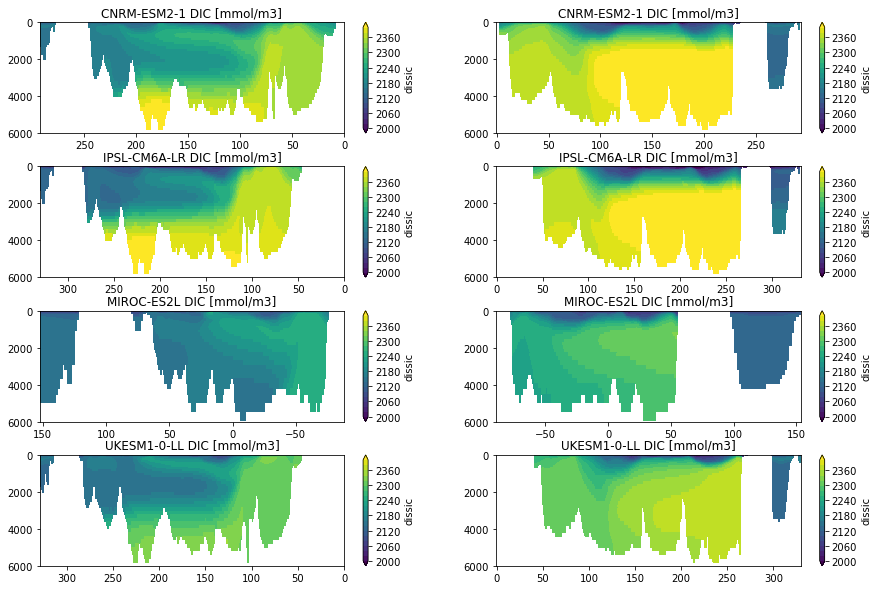

In [54]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=4,figsize=[15, 10])
A = 0
for model in bgcdata_dict.keys():
    if A==2:
        # This model is half Arctic!!
        xlocp=140
        xloca=275
    else:
        xlocp=125
        xloca=255
    (bgcdata_dict[model].dissic.isel(time=slice(-13,-1)).mean('time').isel(x=xloca)*1e3).plot(ax=axes[A,0],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
    (bgcdata_dict[model].dissic.isel(time=slice(-13,-1)).mean('time').isel(x=xlocp)*1e3).plot(ax=axes[A,1],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
    axes[A,0].set_title(model+" DIC [mmol/m3]")
    axes[A,0].set_xlim(bgcdata_dict[model].dissic.y.max(),bgcdata_dict[model].dissic.y.min())
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" DIC [mmol/m3]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4,figsize=[15, 10])
A = 0
for model in bgcdata_dict.keys():
    if A==2:
        # This model is half Arctic!!
        xlocp=140
        xloca=275
    else:
        xlocp=125
        xloca=255
    (bgcdata_dict[model].cpre.isel(time=slice(-13,-1)).mean('time').isel(x=xloca)*1e3).plot(ax=axes[A,0],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
    (bgcdata_dict[model].cpre.isel(time=slice(-13,-1)).mean('time').isel(x=xlocp)*1e3).plot(ax=axes[A,1],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
    axes[A,0].set_title(model+" CPRE [mmol/m3]")
    axes[A,0].set_xlim(bgcdata_dict[model].dissic.y.max(),bgcdata_dict[model].dissic.y.min())
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" CPRE [mmol/m3]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4,figsize=[15, 10])
A = 0
for model in bgcdata_dict.keys():
    if A==2:
        # This model is half Arctic!!
        xlocp=140
        xloca=275
    else:
        xlocp=125
        xloca=255
    (bgcdata_dict[model].creg.isel(time=slice(-13,-1)).mean('time').isel(x=xloca)*1e3).plot(ax=axes[A,0],levels=np.arange(0,320,20),cmap='viridis',extend="both")
    (bgcdata_dict[model].creg.isel(time=slice(-13,-1)).mean('time').isel(x=xlocp)*1e3).plot(ax=axes[A,1],levels=np.arange(0,320,20),cmap='viridis',extend="both")
    axes[A,0].set_title(model+" CREG [mmol/m3]")
    axes[A,0].set_xlim(bgcdata_dict[model].dissic.y.max(),bgcdata_dict[model].dissic.y.min())
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" CREG [mmol/m3]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

Compute linear trend in Cpre and Creg

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4,figsize=[10, 5])
A = 0
for model in bgcdata_dict.keys():
    if A==2:
        # This model is half Arctic!!
        xlocp=140
        xloca=290
    else:
        xlocp=125
        xloca=255
    ds = dsC['dissic']
    DICstore = bgcdata_dict[model].creg.chunk({'time': -1})
    aslope = compute_slope(DICstore.isel(x=xloca))
    aslope = aslope.compute()
    aslope = aslope.mean('member_id')*12 # in mol/m^3/year
    
    pslope = compute_slope(DICstore.isel(x=xlocp))
    pslope = pslope.compute()
    pslope = pslope.mean('member_id')*12 # in mol/m^3/year
    
    aslope.plot(ax=axes[A,0],cmap='RdBu',extend="both")
    pslope.plot(ax=axes[A,1],cmap='RdBu',extend="both")

    axes[A,0].set_title(model+" CREG Trend [mmol/m3/yr]")
    axes[A,0].set_xlim(bgcdata_dict[model].dissic.y.max(),bgcdata_dict[model].dissic.y.min())
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" CREG Trend [mmol/m3/yr]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4,figsize=[10, 5])
A = 0
for model in bgcdata_dict.keys():
    if A==2:
        # This model is half Arctic!!
        xlocp=140
        xloca=290
    else:
        xlocp=125
        xloca=255
    ds = dsC['dissic']
    DICstore = bgcdata_dict[model].cpre.chunk({'time': -1})
    aslope = compute_slope(DICstore.isel(x=xloca))
    aslope = aslope.compute()
    aslope = aslope.mean('member_id')*12 # in mol/m^3/year
    
    pslope = compute_slope(DICstore.isel(x=xlocp))
    pslope = pslope.compute()
    pslope = pslope.mean('member_id')*12 # in mol/m^3/year
    
    aslope.plot(ax=axes[A,0],cmap='RdBu',extend="both")
    pslope.plot(ax=axes[A,1],cmap='RdBu',extend="both")

    axes[A,0].set_title(model+" CPRE Trend [mmol/m3/yr]")
    axes[A,0].set_xlim(bgcdata_dict[model].dissic.y.max(),bgcdata_dict[model].dissic.y.min())
    axes[A,0].set_ylim(6000,0)
    axes[A,0].set_xlabel("")  
    axes[A,0].set_ylabel("")  
    
    axes[A,1].set_title(model+" CPRE Trend [mmol/m3/yr]")
    axes[A,1].set_ylim(6000,0)
    axes[A,1].set_xlabel("")  
    axes[A,1].set_ylabel("") 
    A +=1  
plt.subplots_adjust(hspace=0.3)